# 概要

* 計算物理学入門のP223～P230に掲載されているプログラム md をPythonで再現するためのファイル


In [1]:
import sys
import time

In [2]:
# 変数の宣言

x = [0] * 36
y = [0] * 36
vx = [0] * 36
vy = [0] * 36
ax = [0] * 36
ay = [0] * 36

N = 0
Lx = 0
Ly = 0
dt = 0
dt2 = 0

gcum = []
for i in range(1000):
    gcum.append(i)
nbin = 0
dr = 0
xsave = [0] * 100
ysave = [0] * 100
R2cum = [0] * 100

# 変数の宣言２(グローバルで扱ったほうが良いものを追加している)
t = 0
ke = 0
kecum = 0
pecum = 0
vcum = 0
area = 0
pbc = 0

pe = 0
virial = 0

dx = 0
dy = 0
fx = 0
fy = 0
fxij = 0
fyij = 0
pot = 0

In [3]:
def initial():
    global pbc
    abc = 0
    global dt
    dt = 0.01
    global dt2
    dt= dt * dt
    
    response = ""
    global N
    N = 16
    global Lx
    Lx = 6
    global Ly
    Ly = 6
    
    DATA = [
        1.09,0.98,-0.33,0.78,3.12,5.25,0.12,-1.19
      , 0.08,2.38,-0.08,-0.10,0.54,4.08,-1.94,-0.56
      , 2.52,4.39,0.75,0.34,3.03,2.94,1.70,-1.08
      , 4.25,3.01,0.84,0.47,0.89,3.11,-1.04,0.06
      , 2.76,0.31,1.64,1.36,3.14,1.91,0.38,-1.24
      , 0.23,5.71,-1.58,0.55,1.91,2.46,-1.55,-0.16
      , 4.77,0.96,-0.23,-0.83,5.10,4.63,-0.31,0.65
      , 4.97,5.88,1.18,1.48,3.90,0.20,0.46,-0.51
    ]
    
    global x
    global y
    global vx
    global vy
    
    for i in range(N):
        x[i] = DATA[4*i+0]
        y[i] = DATA[4*i+1]
        vx[i] = DATA[4*i+2]
        vy[i] = DATA[4*i+3]
    
    global ke
    ke = 0
    for i in range(N):
        ke = ke + vx[i]* vx[i] + vy[i]* vy[i]
    ke = 0.5 * ke
    global area
    area = Lx * Ly
    global t
    t = 0
    global kecum
    kecum = 0
    global pecum
    pecum = 0
    global vcum
    vcum = 0    

In [4]:
def separation(ds, L):
    if (ds > 0.5 * L):
        return ds - L
    elif (ds < -0.5 * L):
        return ds + L
    else:
        return ds

In [5]:
def force():
    global dx
    global dy
    global fx
    global fy
    global fxij
    global fyij
    global pot
    r2 = dx*dx + dy*dy
    rm2 = 1/r2
    rm6 = rm2 * rm2 * rm2
    f_over_r = 24 * rm6 * (2 * rm6 - 1) * rm2
    fx = f_over_r * dx
    fy = f_over_r * dy
    pot = 4 * (rm6 * rm6 - rm6)

In [6]:
def accel():
    global pe
    pe = 0
    global virial
    virial = 0
    global N
    print(N)
    global x
    global y
    global Lx
    global Ly
    global ax
    global ay
    global dx
    global dy
    for i in range(N-1):
        for j in range(i+1, N):
            dx = separation(x[i] - x[j], Lx)
            dy = separation(y[i] - y[j], Ly)
            force()
            ax[i] = ax[i] + fxij
            ay[i] = ay[i] + fyij
            ax[j] = ax[j] - fxij
            ay[j] = ay[j] - fyij
            pe = pe + pot
            virial = virial + dx*fxij + dy*fyij
            

In [7]:
def pbc(pos, L):
    if (pos < L):
        return (pos+L)
    elif(pos > L):
        return (pos-L)
    else:
        return (pos)
    

In [8]:
def Verlet():
    global x
    global y
    global vx
    global vy
    global ax
    global ay
    global N
    global Lx
    global Ly
    global dt
    global dt2
    global ke
    global t
    
    for i in range(N):
        xnew = x[i] + vx[i] * dt + 0.5 * ax[i] * dt2
        ynew = y[i] + vy[i] * dt + 0.5 * ay[i] * dt2
        vx[i] = vx[i] + 0.5 * ax[i] * dt
        vy[i] = vy[i] + 0.5 * ay[i] * dt
        x[i] = pbc(xnew, Lx)
        y[i] = pbc(ynew, Ly)
        
    accel()
        
    ke = 0
    for i in range(N):
        vx[i] = vx[i] + 0.5 * ax[i] * dt
        vy[i] = vy[i] + 0.5 * ay[i] * dt
        ke = ke + vx[i] * vx[i] + vy[i] * vy[i]
        ke = 0.5 * ke
        t = t + 1

In [9]:
def show_output():
    global t
    global ke
    global pe
    global virial
    global kecum
    global vcum
    global ncum
    global area
    global N
    global Lx
    global Ly

    ncum = ncum + 1
    sys.stdout.write("\r %s" % "ncum:"+str(ncum))
    sys.stdout.write("%s" % "t:"+str(t))
    E = ke + pe
    sys.stdout.write("%s" % "E:"+str(E))
    kecum = kecum + ke
    vcum = vcum + virial
    mean_ke = kecum / ncum
    p = mean_ke + (0.5 * vcum) / ncum
    p = p / area
    sys.stdout.write("%s" % "mean_ke/N:"+str(mean_ke/N))
    sys.stdout.write("%s" % "p:"+str(p))
    sys.stdout.flush()
    time.sleep(0.1)

In [10]:
initial()
accel()
E = ke + pe
ncum = 0
flag = True
while (flag):
#     show_positions(flag)
    Verlet()
    show_output()
    
save_config()

16
16
 ncum:1t:16E:-16.142919794946767mean_ke/N:0.08743400945663453p:0.03885955975850423316
 ncum:2t:32E:-16.140459012706845mean_ke/N:0.08743400945663453p:0.03885955975850423316
 ncum:3t:48E:-16.137987072035035mean_ke/N:0.08743400945663453p:0.03885955975850423316
 ncum:4t:64E:-16.135503955466394mean_ke/N:0.08743400945663453p:0.03885955975850423316
 ncum:5t:80E:-16.13300964543591mean_ke/N:0.08743400945663453p:0.03885955975850423316
 ncum:6t:96E:-16.130504124278282mean_ke/N:0.08743400945663453p:0.03885955975850423316
 ncum:7t:112E:-16.127987374227764mean_ke/N:0.08743400945663451p:0.0388595597585042316
 ncum:8t:128E:-16.125459377418146mean_ke/N:0.08743400945663451p:0.0388595597585042316
 ncum:9t:144E:-16.122920115882515mean_ke/N:0.08743400945663451p:0.0388595597585042316
 ncum:10t:160E:-16.120369571553233mean_ke/N:0.08743400945663451p:0.0388595597585042316
 ncum:11t:176E:-16.117807726261763mean_ke/N:0.0874340094566345p:0.0388595597585042216
 ncum:12t:192E:-16.115234561738582mean_ke/N:0.08

KeyboardInterrupt: 

AttributeError: 'Axes3D' object has no attribute 'plot_fireframe'

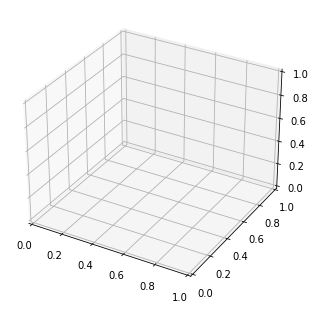

In [11]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(-3, 3, 0.25)
y = np.arange(-3, 3, -.25)
X, Y = np.meshgrid(x, y)
Z = np.sin(X) + np.cos(Y)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_fireframe(X, Y, Z)

plt.show()

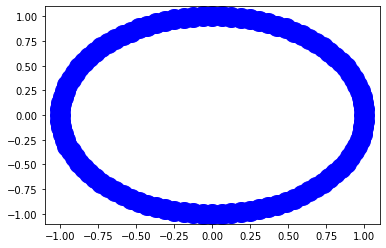

In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

dt = 0.01
fig = plt.figure()
ims = []

for i in range(int(1/dt)):
	t = dt*i
	
	x = np.cos(t*2*np.pi)
	y = np.sin(t*2*np.pi)
	im = plt.plot(x,y,color='b', marker='o', markersize=20)
	ims.append(im)

ani = animation.ArtistAnimation(fig,ims)
plt.show()